In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

# Carregando e limpando os dados

In [82]:
pagamentos = pd.read_csv('pagamentos.csv')
pagamentos.info()
# pagamentos.value_counts()
print(pagamentos.nunique())
pagamentos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427873 entries, 0 to 427872
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   data_publicacao          427873 non-null  object
 1   fase                     427873 non-null  object
 2   credor                   427873 non-null  object
 3   valor                    427873 non-null  object
 4   numero                   427873 non-null  object
 5   cpf_ou_cnpj              427873 non-null  object
 6   data_pagamento           427873 non-null  object
 7   numero_processo          253290 non-null  object
 8   bem_ou_servico_prestado  420978 non-null  object
 9   natureza                 422333 non-null  object
 10  acao                     407378 non-null  object
 11  funcao                   407414 non-null  object
 12  subfuncao                407405 non-null  object
 13  processo_licitatorio     407396 non-null  object
 14  fonte_recurso       

,data_publicacao,fase,credor,valor,numero,cpf_ou_cnpj,data_pagamento,numero_processo,bem_ou_servico_prestado,natureza,acao,funcao,subfuncao,processo_licitatorio,fonte_recurso
0,01/01/2010,EMPENHO,METALPIRES INDUSTRIA E COM LT,"R$ 203.690,00",10000348,06.965.538/0001-00,01/01/2010,157/2009,REF AQUISICAO DE MOBILIARIOS E EQUIPAMENTOS PA...,449052090000 - Out.Equip. e Mat. Permanente,2040 - Equipar e Reequipar Unidades Escolares ...,12 - EDUCACAO,361 - ENSINO FUNDAMENTAL,PREGAO,0001 - REC.IMP.TRANSF.EDUCACAO 25%
1,01/01/2010,EMPENHO,INST.NAC.DE SEGURIDADE SOCIAL,"R$ 1.500.000,00",10000195,01.404.357/0001-51,01/01/2010,NaN,REFERENTE A DESPESA COM PARCE- LAMENTO DA DI...,469071030000 - INSS/PARCELAMENTO,2145 - Administracao de encagos especiais,28 - ENCARGOS ESPECIAIS,843 - SERVICO DA DIVIDA INTERNA,ISENTO,0000 - RECURSOS ORDINARIOS
2,01/01/2010,EMPENHO,GASAUTO LOCAC?O DE VEICULOS L,"R$ 18.816,00",113/2009,00.426.288/0001-58,01/01/2010,039/2009,locac?o de 04 motocicletas 150cc com com parti...,339039780000 - locacao de veiculos,2141 - Seguranca no transito,26 - TRANSPORTE,452 - SERVICOS URBANOS,CONVITE,0050 - REC.PROPRIAS ENT.ADM.
3,02/01/2010,EMPENHO,SALUSTIANO JOSE ALVES DIAS,"R$ 4.800,00",10000024,407.981.865-34,02/01/2010,230/2007,"TERMO DE RENOVACAO DO ADITIVO 5025271/2009, R...",339039780000 - locacao de veiculos,2097 - Pavimentacao e infra-estrutura,15 - URBANISMO,451 - INFRA-ESTRUTURA URBANA,TOMADA DE PRECO,0000 - RECURSOS ORDINARIOS
4,02/01/2010,EMPENHO,VALDEANE DOS SANTOS DIAS,"R$ 3.600,00",10000494,006.534.185-66,02/01/2010,NaN,REF. ALUGUEL DO IMOVEL ONDE FUNCIONA O NUCL...,339039100000 - Locacao de imoveis,2084 - Programa Errad.Trabalho Infantil PETI,08 - ASSISTENCIA SOCIAL,243 - ASSISTENCIA A CRIANCA E AO ADO,ISENTO,0000 - RECURSOS ORDINARIOS


In [83]:
# Removendo duplicatas
pagamentos = pagamentos[pagamentos['fase'] == 'PAGAMENTO']
pagamentos.drop(['data_publicacao', 'fase', 'numero', 
                'cpf_ou_cnpj', 'data_pagamento', 'numero_processo'],
                inplace=True, axis=1)
print(pagamentos.info())
print(pagamentos.nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181527 entries, 13 to 427868
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   credor                   181527 non-null  object
 1   valor                    181527 non-null  object
 2   bem_ou_servico_prestado  179835 non-null  object
 3   natureza                 175987 non-null  object
 4   acao                     161047 non-null  object
 5   funcao                   161068 non-null  object
 6   subfuncao                161059 non-null  object
 7   processo_licitatorio     161057 non-null  object
 8   fonte_recurso            161059 non-null  object
dtypes: object(9)
memory usage: 13.8+ MB
None
credor                      7505
valor                      83054
bem_ou_servico_prestado    93641
natureza                     556
acao                         526
funcao                        36
subfuncao                     61
processo_licitator

In [84]:
num_entradas_repetidas = len(pagamentos)
pagamentos = pagamentos.drop_duplicates()
num_entradas_unicas = len(pagamentos)
print(f'Numero de entradas duplicadas: {num_entradas_repetidas - num_entradas_unicas}\nNumero de entradas unicas: {num_entradas_unicas}')

Numero de entradas duplicadas: 21316
Numero de entradas unicas: 160211


In [85]:
# Limpando float
def currency_to_float(value):
    """Converte de R$ 69.848,70 (str) para 69848.70 (float)."""
    try:
        cleaned_value = value.replace("R$", "").replace(".", "").replace(",", ".")
        return float(cleaned_value)
    except ValueError:
        return

pagamentos['valor'] = pagamentos['valor'].apply(currency_to_float)
pagamentos.valor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160211 entries, 13 to 427803
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   credor                   160211 non-null  object 
 1   valor                    160211 non-null  float64
 2   bem_ou_servico_prestado  158900 non-null  object 
 3   natureza                 155488 non-null  object 
 4   acao                     141462 non-null  object 
 5   funcao                   141482 non-null  object 
 6   subfuncao                141474 non-null  object 
 7   processo_licitatorio     141472 non-null  object 
 8   fonte_recurso            141474 non-null  object 
dtypes: float64(1), object(8)
memory usage: 12.2+ MB


# Detectando outliers

In [91]:
# Pegando somente dados pra usar na detecção de outliers
df_credores = pagamentos[['credor', 'valor']]
grupo_credores = df_credores.groupby('credor').agg(['count', 'sum'])
grupo_credores.columns = grupo_credores.columns.get_level_values(1)
grupo_credores = grupo_credores.sort_values('count', ascending=False)

grupo_credores.head(20)

,count,sum
credor,,
coelba,5008,4.899646e+07
i n s s folha,4775,2.034681e+07
coopersade coop s p esp saude,4038,1.298119e+08
i n s s s processos,3080,1.364675e+07
telemar,2259,7.895832e+06
sind emp t col feira santan,2097,1.876241e+07
auto posto gasauto ltda,2004,1.445869e+07
embasa emp baiana sanea,1816,2.969798e+07
embasa emp baiana agua sane,1456,1.662131e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f26186d13d0>,
      dtype=object)

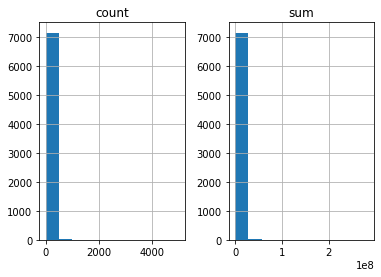

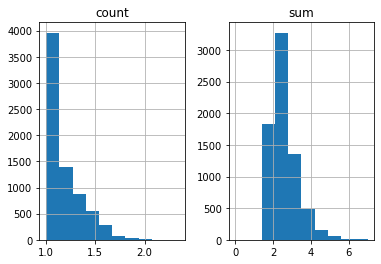

In [92]:
# Transformando as entradas pra uma forma mais gaussiana
grupo_credores.hist()

gp_cred_gaus = grupo_credores.transform(lambda x: x ** (1/10))
gp_cred_gaus.hist()

In [97]:
# Detectando outliers

#LocalOutlierFactor
lof = LocalOutlierFactor()
# lof.fit_predict(gp_cred_gaus)
gp_cred_gaus['outlier_lof'] = (lof.fit_predict(gp_cred_gaus) < 0)
num_outliers_lof_transf = gp_cred_gaus['outlier_lof'].sum()
print(f'Num outliers utilizando tecnica LOF nos dados transformados: {num_outliers_lof_transf}')

grupo_credores['outlier_lof'] = (lof.fit_predict(grupo_credores) < 0)
num_outliers_lof_orig = grupo_credores['outlier_lof'].sum()
print(f'Num outliers utilizando tecnica LOF. Dados originais: {num_outliers_lof}')

Num outliers utilizando tecnica LOF nos dados transformados: 299
Num outliers utilizando tecnica LOF. Dados originais: 591


In [98]:
# EllipticEnvelope (gaussian)
# TODO: verificar threshold
cov = EllipticEnvelope(random_state=0).fit(gp_cred_gaus)
gp_cred_gaus['outlier_gaus'] = (cov.predict(gp_cred_gaus) < 0)
num_outliers_gaus_transf = gp_cred_gaus['outlier_gaus'].sum()
print(f'Num outliers utilizando tecnica gaussiana. Dados transformados: {num_outliers_gaus_transf}')

cov = EllipticEnvelope(random_state=0).fit(grupo_credores)
grupo_credores['outlier_gaus'] = (cov.predict(grupo_credores) < 0)
num_outliers_gaus_orig = grupo_credores['outlier_gaus'].sum()
print(f'Num outliers utilizando tecnica gaussiana nos dados originais: {num_outliers_gaus_orig}')

Num outliers utilizando tecnica gaussiana. Dados transformados: 719
Num outliers utilizando tecnica gaussiana nos dados originais: 719


In [ ]:
gp_cred_gaus['outlier_or'] = np.logical_or(gp_cred_gaus['outlier_lof'], gp_cred_gaus['outlier_gaus'])
gp_cred_gaus['outlier_xor'] = np.logical_xor(gp_cred_gaus['outlier_lof'], gp_cred_gaus['outlier_gaus'])

grupo_credores['outlier_or'] = np.logical_or(grupo_credores['outlier_lof'], grupo_credores['outlier_gaus'])
grupo_credores['outlier_xor'] = np.logical_xor(grupo_credores['outlier_lof'], grupo_credores['outlier_gaus'])

gp_cred_gaus.head(10)

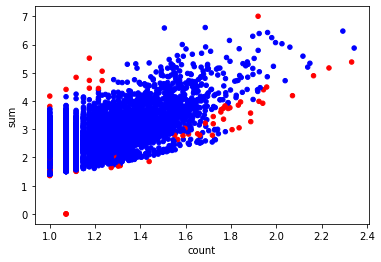

In [99]:
gp_cred_gaus['color'] = np.where(gp_cred_gaus['outlier_lof'] == True, 'red', 'blue')
# gp_cred_gaus['color'] = np.where(gp_cred_gaus['outlier_xor'] == True, 'orange', gp_cred_gaus['color'])

scatter_plt = gp_cred_gaus.plot.scatter(x='count', y='sum', c=gp_cred_gaus['color'])

# for i, cred in enumerate(gp_cred_gaus.index):
#     if i > 10:
#         break
#     scatter_plt.annotate(cred,
#                          (gp_cred_gaus['count'].iat[i], gp_cred_gaus['sum'].iat[i]),
#                           )
plt.show()

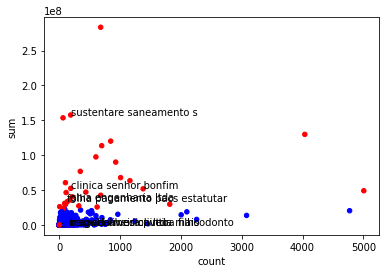

In [119]:
grupo_credores['color'] = np.where(grupo_credores['outlier_lof'] == True, 'red', 'blue')
# grupo_credores['color'] = np.where(grupo_credores['outlier_xor'] == True, 'orange', grupo_credores['color'])

scatter_plt = grupo_credores.plot.scatter(x='count', y='sum', c=grupo_credores['color'])

for i, cred in enumerate(grupo_credores.index):
    if(i<100):
        continue
    if (i>200):
        break
    if (not grupo_credores.iloc[i, 2]):
        continue
    scatter_plt.annotate(cred, (grupo_credores['count'].iat[i], grupo_credores['sum'].iat[i]))
plt.show()